<a href="https://colab.research.google.com/github/olesyaRU/OlesyaRepository/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6_ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Однофакторный дисперсионный анализ (ANOVA)

In [ ]:
# загрузим необходимые пакеты
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np


In [ ]:
pip install pingouin

### **Пример 1.** Генотерапия позволяет корректировать работу дефективного гена, ответственного за развитие заболевания. Например, можно попытаться увеличить уровень экспрессии дефективного гена. Для этого существуют различные способы. В рамках эксперимента была проведена оценка эффективности четырех различных методов терапии.

Часто в экспериментах и исследованиях возникает необходимость сравнить несколько групп между собой. В этом случае мы можем применять **однофакторный дисперсионный анализ**.  

Та переменная, которая будет разделять наших испытуемых или наблюдения на группы (номинативная переменная с нескольким градациями) называется **независимой** переменной.

Количественная переменная, по степени выраженности которой мы сравниваем группы, называется **зависимая** переменная.

**Условия применимости дисперсионного анализа**:
1. Нормальное распределение
2. Гомогенность дисперсии

In [ ]:
#загрузим набор данных геннотерапии
gen=pd.read_csv('/content/drive/MyDrive/genetherapy.csv')

In [ ]:
# посмотрим что собой представляет датасет
gen

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A
5,99,A
6,97,A
7,96,A
8,98,A
9,106,A


### **Н0**: средние значения уровня экспрессии дефективного гена после применения четырёх методов терапии не отличаются.

Здесь **Therapy** - независимая категориальная переменная, представляющая 4 вида терапии.

**expr** - зависимая числовая переменная

In [ ]:
gen.describe()

,expr
count,60.000000
mean,96.316667
std,5.619252
min,84.000000
25%,93.000000
50%,96.000000
75%,100.000000
max,107.000000


In [ ]:
gen.describe(include='object')

,Therapy
count,60
unique,4
top,A
freq,15


In [ ]:
# сгруппируем данные по виду терапии.
# Вычислим среднее, стандартное отклонение и количество переменной экспрессии гена по каждому виду терапии
summary_table = gen.groupby('Therapy')['expr'].agg(['mean', 'std', 'count']).round(2)

print(summary_table)

          mean   std  count
Therapy                    
A        99.73  4.17     15
B        98.80  5.89     15
C        94.40  5.19     15
D        92.33  3.74     15


## Проверка на нормальность

In [ ]:
from scipy.stats import shapiro
import pandas as pd

# Создаем список для хранения результатов теста на нормальность
normality_results = []

# Группируем данные по Therapy
for therapy_value, group_data in gen.groupby('Therapy')['expr']:
    result = shapiro(group_data)
    normality_results.append({'Therapy': therapy_value, 'p-value': result.pvalue, 'is_normal': result.pvalue > 0.05})

# Создаем DataFrame для результатов
normality_df = pd.DataFrame(normality_results)

# Выводим результаты
print(normality_df)

  Therapy   p-value  is_normal
0       A  0.062011       True
1       B  0.237399       True
2       C  0.261579       True
3       D  0.999785       True


## Визуализируем распределения

<Figure size 1200x600 with 0 Axes>

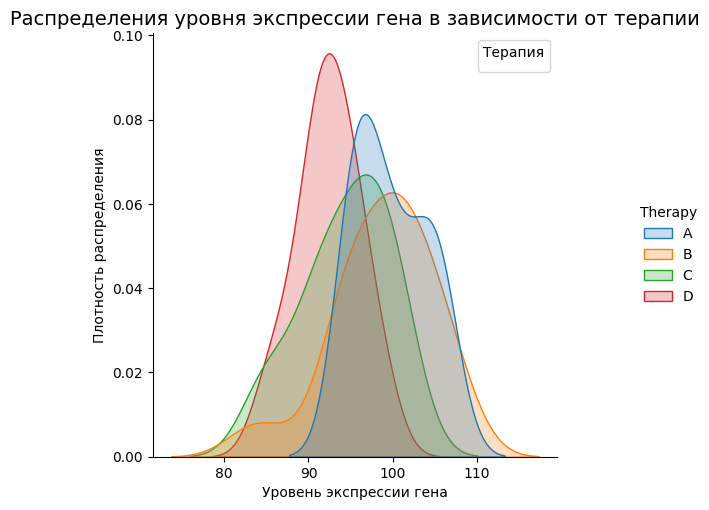

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Создаем отдельные графики распределений переменной expr для разных значений Therapy
plt.figure(figsize=(12, 6))
sns.displot(data=gen, x='expr', hue='Therapy', kind='kde', fill=True, common_norm=False)
plt.title('Распределения уровня экспрессии гена в зависимости от терапии', fontsize=14)
plt.xlabel('Уровень экспрессии гена')
plt.ylabel('Плотность распределения')
plt.legend(title='Терапия')
plt.show()

## Гомогенность дисперсии

Сначала визуализируем данные с помощью графика боксплот. Посмотрим есть ли выбросы.

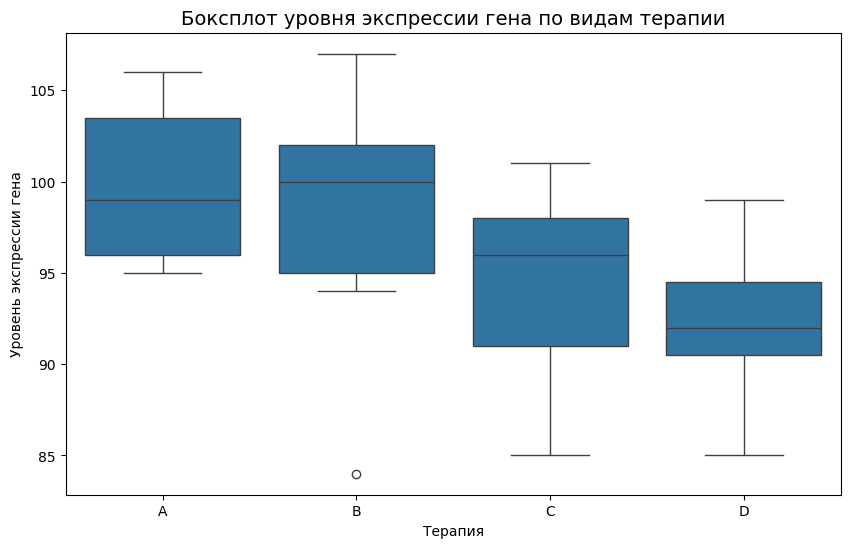

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Создаем боксплоты переменной expr для разных значений Therapy
plt.figure(figsize=(10, 6))
sns.boxplot(data=gen, x='Therapy', y='expr')
plt.title('Боксплот уровня экспрессии гена по видам терапии', fontsize=14)
plt.xlabel('Терапия')
plt.ylabel('Уровень экспрессии гена')
plt.show()

## Тест Левена

**H0**: дисперсии уровня экспрессии гена во всех 4-х группах равны.

Воспользуемся **тестом Левена**, используя функцию **levene()** из библиотеки **SciPy**, которая использует следующий синтаксис:

levene (sample1, sample2, …, center = '...')

где:

**sample1, sample2** и т. д.: названия групп.

**center**: метод, используемый для теста Левена.

По умолчанию используется «медиана», но другие варианты включают «среднее» и «усеченное».

«**median**»: рекомендуется для асимметричных распределений.

«**mean**»: рекомендуется для симметричных распределений со средними хвостами.

«**trimmed**»: рекомендуется для распределений с тяжелыми хвостами.

In [ ]:
import scipy.stats as stats

data_A = gen[gen['Therapy'] == 'A']['expr']
data_B = gen[gen['Therapy'] == 'B']['expr']
data_C = gen[gen['Therapy'] == 'C']['expr']
data_D = gen[gen['Therapy'] == 'D']['expr']

# Проведём тест Левена для проверки гомогенности дисперсий
stats.levene(data_A, data_B, data_C, data_D, center='mean')

LeveneResult(statistic=1.071764658870044, pvalue=0.3684919438820897)

p-уровень значимости больше, чем 0,05. Нулевую гипотезу принимаем, значит во всех 4-х группах дисперсии равны.
Можно делать дисперсионный анализ.

### Проводим однофакторный дисперсионный анализ

### 1 вариант

In [ ]:
# Выделяем группы для каждого значения переменной Therapy
groups = [gen[gen['Therapy'] == group]['expr'] for group in gen['Therapy'].unique()]

# Проводим однофакторный дисперсионный анализ с помощью функции f_oneway пакета scipy.stats
f_statistic, p_value = f_oneway(*groups)

# Выводим результаты
print("F-статистика:", f_statistic)
print("p-значение:", p_value)

F-статистика: 8.03730248114399
p-значение: 0.00015249722895229536


### 2 вариант

In [ ]:
# Проводим однофакторный дисперсионный анализ с помощью библиотеки statsmodels
model = ols('expr ~ Therapy', data=gen).fit()
anova_results = anova_lm(model)

# Выводим результаты
print(anova_results)

            df       sum_sq     mean_sq         F    PR(>F)
Therapy    3.0   560.716667  186.905556  8.037302  0.000152
Residual  56.0  1302.266667   23.254762       NaN       NaN


p-уровень значимость меньше 0,05, значит нулевую гипотезу отклоняем. Это означает, что как минимум 2 средних значимо отличаются между собой.

Визуализируем данные с помощью доверительных интервалов с указанием среднего значения

<ipython-input-14-394a77be2448>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x='Therapy', y='expr', data=gen, ci=95, capsize=.1, join=False)
<ipython-input-14-394a77be2448>:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Therapy', y='expr', data=gen, ci=95, capsize=.1, join=False)


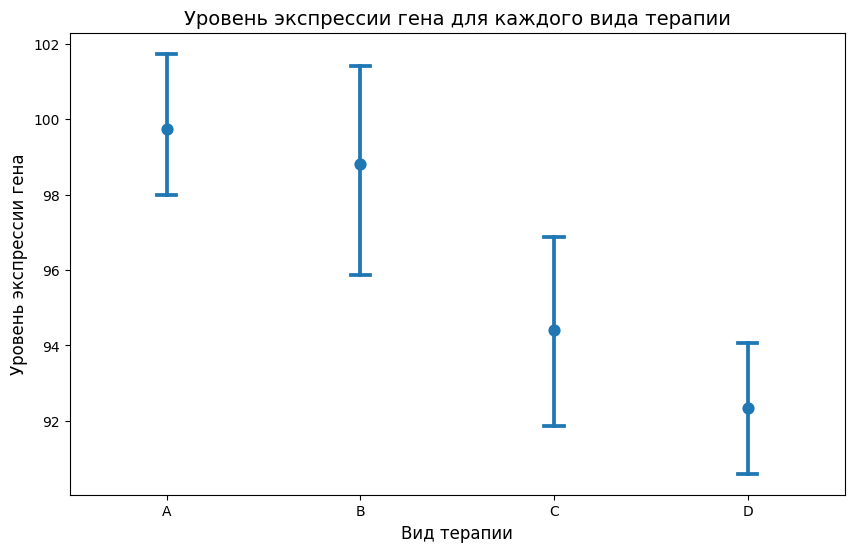

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='Therapy', y='expr', data=gen, ci=95, capsize=.1, join=False)
plt.xlabel('Вид терапии', fontsize=12)
plt.ylabel('Уровень экспрессии гена', fontsize=12)
plt.title('Уровень экспрессии гена для каждого вида терапии', fontsize=14)
plt.show()

Первые 2 вида. терапии (А и В) лучше справляются с поставленной задачей, чем терапии С и D.

Между какими именно парами средних существуют значимые различия (что показал нам дисперсионный анализ)?

Если доверительные интервалы не включают средние значения друг друга, то такие различия будут значимыми.

# Множественные сравнения в ANOVA
## **Критерий Тьюки**

In [ ]:
tukey = pairwise_tukeyhsd(endog = gen['expr'], groups = gen['Therapy'], alpha = 0.05)

tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.9333,0.9514,-5.5959,3.7292,False
A,C,-5.3333,0.0189,-9.9959,-0.6708,True
A,D,-7.4,0.0005,-12.0626,-2.7374,True
B,C,-4.4,0.071,-9.0626,0.2626,False
B,D,-6.4667,0.0029,-11.1292,-1.8041,True
C,D,-2.0667,0.6458,-6.7292,2.5959,False


Группы A и C, A и D, B и D - значимо отличаются между собой

# Двухфакторный дисперсионный анализ

### **Пример 2.** Атеросклероз -опасное заболевание, причина ишемической болезни сердца и инсультов.
Анализ экспрессии генов лейкоцитов позволяет предсказать вероятность развития данного заболевания.

### В эксперименте исследовался уровень экспрессии в зависимости от возраста пациента и дозировки лекарства аторвастатина.

In [ ]:
ater=pd.read_csv('/content/drive/MyDrive/atherosclerosis.csv')

In [ ]:
ater

,expr,age,dose
0,107.351478,1,D1
1,104.504438,1,D1
2,103.435134,1,D1
3,109.572882,1,D1
4,114.993803,1,D1
...,...,...,...
59,101.851582,2,D2
60,105.239530,2,D2
61,99.350198,2,D2
62,108.091455,2,D2


## Проверка на нормальность

In [ ]:
from scipy.stats import shapiro
import pandas as pd

# Создаем список для хранения результатов теста на нормальность
normality_results = []

# Группируем данные по дозе гормона
for therapy_value, group_data in ater.groupby('dose')['expr']:
    result = shapiro(group_data)
    normality_results.append({'dose': therapy_value, 'p-value': result.pvalue, 'is_normal': result.pvalue > 0.05})

# Создаем DataFrame для результатов
normality_ater = pd.DataFrame(normality_results)

# Выводим результаты
print(normality_ater)

  dose   p-value  is_normal
0   D1  0.657519       True
1   D2  0.312118       True


In [ ]:
from scipy.stats import shapiro
import pandas as pd

# Создаем список для хранения результатов теста на нормальность
normality_results = []

# Группируем данные по возрасту
for therapy_value, group_data in ater.groupby('age')['expr']:
    result = shapiro(group_data)
    normality_results.append({'age': therapy_value, 'p-value': result.pvalue, 'is_normal': result.pvalue > 0.05})

# Создаем DataFrame для результатов
normality_ater1 = pd.DataFrame(normality_results)

# Выводим результаты
print(normality_ater1)

   age   p-value  is_normal
0    1  0.204928       True
1    2  0.713377       True


## Гомогенность дисперсии

In [ ]:
import scipy.stats as stats

data_1 = ater[ater['dose'] == 'D1']['expr']
data_2 = ater[ater['dose'] == 'D2']['expr']

# Проводим тест Левена для проверки гомогенности дисперсий
stats.levene(data_1, data_2, center='mean')

LeveneResult(statistic=0.03931943734898134, pvalue=0.8434659230532853)

In [ ]:
import scipy.stats as stats

dat_1 = ater[ater['age'] == 1]['expr']
dat_2 = ater[ater['age'] == 2]['expr']

# Проводим тест Левена для проверки гомогенности дисперсий
stats.levene(dat_1, dat_2, center='mean')

LeveneResult(statistic=0.08436868351041557, pvalue=0.772431504114608)

### Дисперсионный анализ

In [ ]:
#Дисперсионный анализ
model = ols('expr ~ dose + age + dose:age', data=ater).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
dose,16.912241,1.0,0.638094,0.427552
age,197.452754,1.0,7.449841,0.008313
dose:age,0.927077,1.0,0.034978,0.852272
Residual,1590.257424,60.0,NaN,NaN


### Визуализация

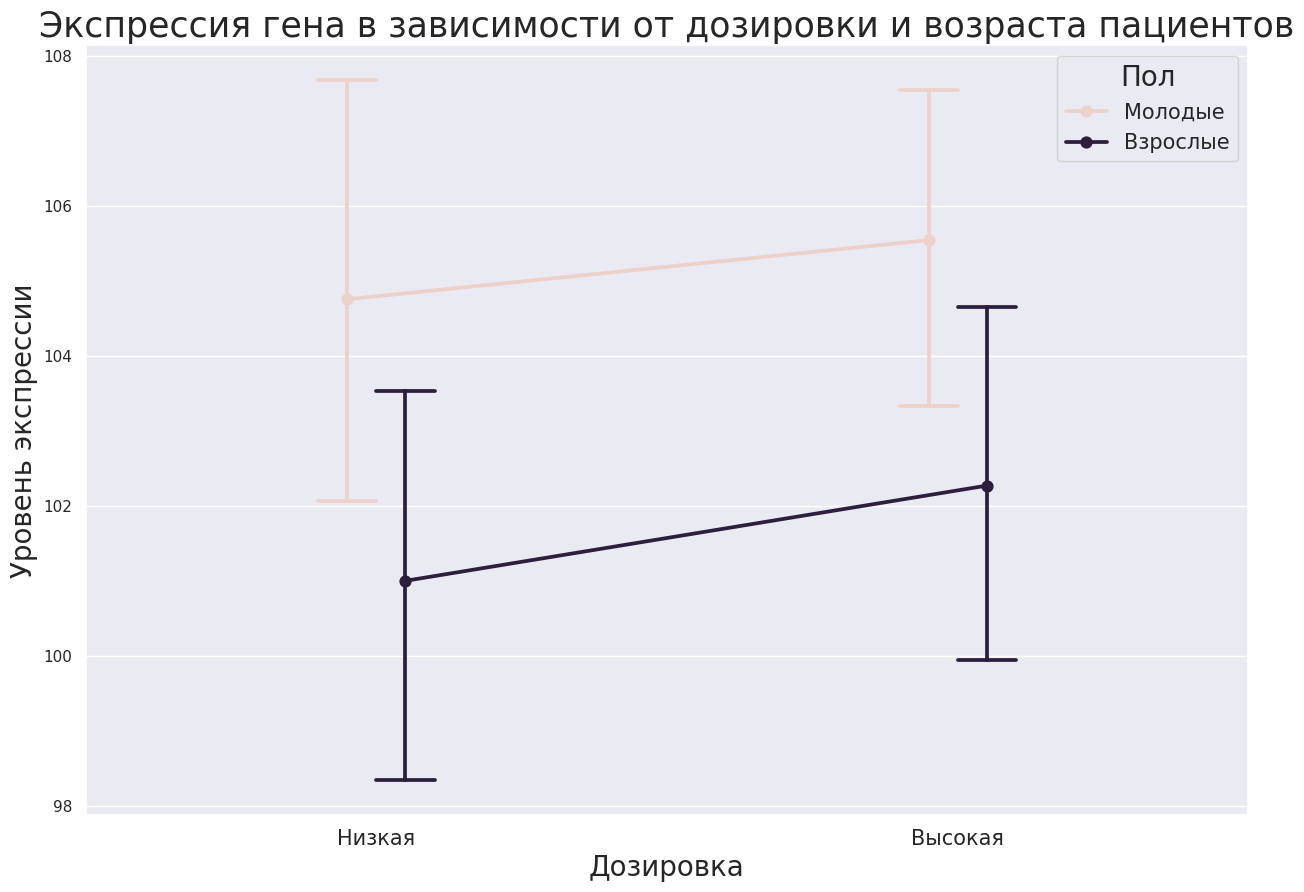

In [ ]:
# задаем размеры выводимого графика
sns.set(rc={'figure.figsize':(15, 10)})

# строим график с помощью seaborn
pplot = sns.pointplot(x='dose', y='expr', hue='age', dodge=0.1, capsize=.1, data=ater)

# меняем названия титула, оси х и оси у
plt.title('Экспрессия гена в зависимости от дозировки и возраста пациентов', fontsize=25)
plt.xlabel('Дозировка', fontsize=20)
plt.ylabel('Уровень экспрессии', fontsize=20)

# меняем названия отложенных по оси х значений
bars = ('Низкая', 'Высокая')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, fontsize=15)

# меняем "Легенду"
leg_handles = pplot.get_legend_handles_labels()[0]
pplot.legend(leg_handles, ['Молодые', 'Взрослые'], title='Пол', title_fontsize=20, fontsize=15)

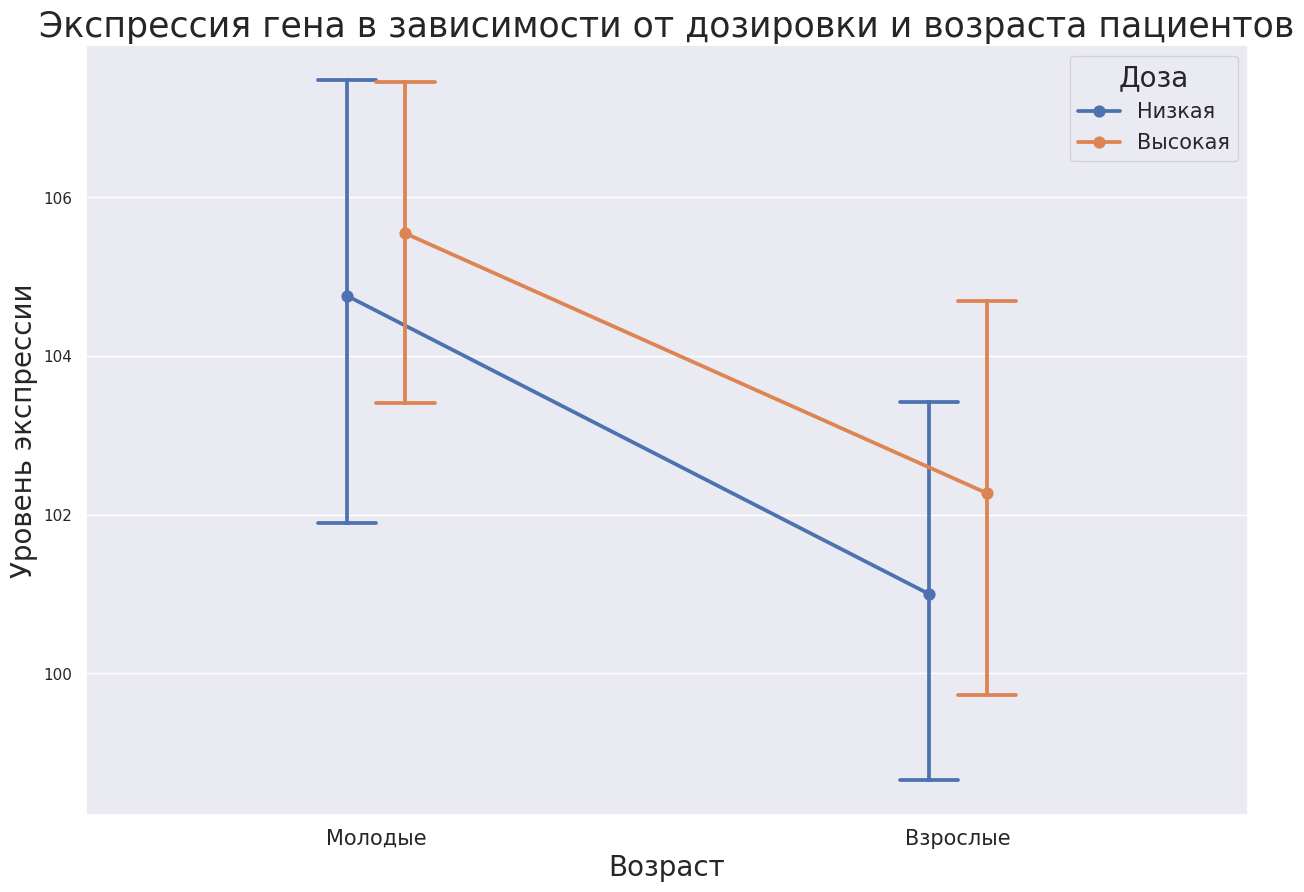

In [ ]:
# задаем размеры выводимого графика
sns.set(rc={'figure.figsize':(15, 10)})

# строим график с помощью seaborn
pplot = sns.pointplot(x='age', y='expr', hue='dose', dodge=0.1, capsize=.1, data=ater)

# меняем названия титула, оси х и оси у
plt.title('Экспрессия гена в зависимости от дозировки и возраста пациентов', fontsize=25)
plt.xlabel('Возраст', fontsize=20)
plt.ylabel('Уровень экспрессии', fontsize=20)

# меняем названия отложенных по оси х значений
bars = ('Молодые', 'Взрослые')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, fontsize=15)

# меняем "Легенду"
leg_handles = pplot.get_legend_handles_labels()[0]
pplot.legend(leg_handles, ['Низкая', 'Высокая'], title='Доза', title_fontsize=20, fontsize=15)

### **Пример 3.** Влияние гормона на показатель концентрации кальция в крови с учетом пола.

In [ ]:
data1

,var4,hormone,sex
0,17.859039,1,1
1,20.842343,1,1
2,19.318099,1,1
3,20.064451,1,1
4,17.620316,1,1
...,...,...,...
59,17.054195,0,0
60,22.951551,0,0
61,18.799382,0,0
62,16.543161,0,0


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   var4     64 non-null     float64
 1   hormone  64 non-null     int64  
 2   sex      64 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.6 KB


In [ ]:
#Дисперсионный анализ
data1 = pd.read_csv('/content/drive/MyDrive/gormon.csv')
model = ols('var4 ~ hormone + sex + hormone:sex', data=data1).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
hormone,0.847472,1.0,0.086528,0.769653
sex,0.119762,1.0,0.012228,0.912318
hormone:sex,89.483384,1.0,9.136390,0.003682
Residual,587.650394,60.0,NaN,NaN


Ни один из факторов не оказывает значимого влияния на концентрацию кальция в крови, но их взаимодействие оказывает.

Построим график результатов

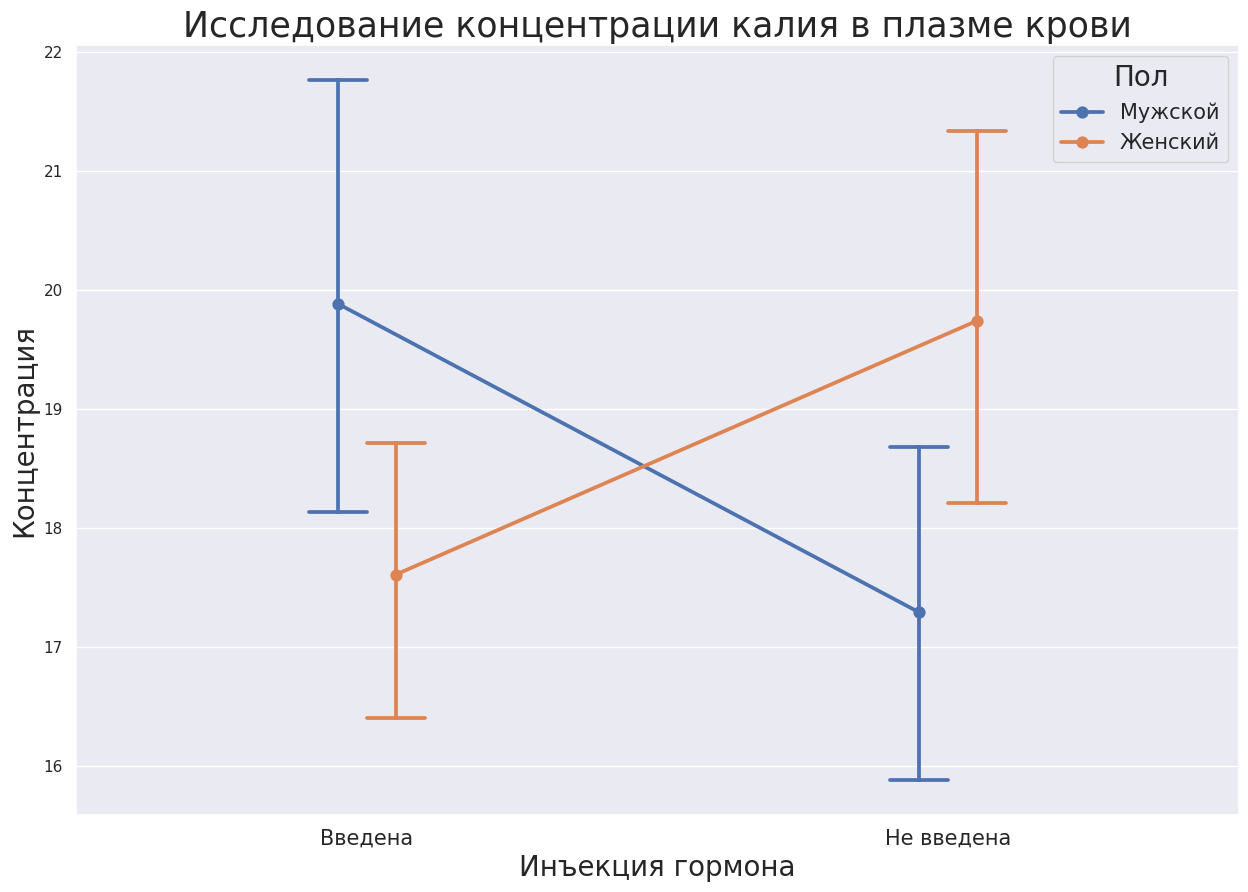

In [ ]:
# задаем размеры выводимого графика
sns.set(rc={'figure.figsize':(15, 10)})

# строим график с помощью seaborn
pplot = sns.pointplot(x='hormone', y='var4', hue='sex', dodge=0.1, capsize=.1, data=data1)

# меняем названия титула, оси х и оси у
plt.title('Исследование концентрации калия в плазме крови', fontsize=25)
plt.xlabel('Инъекция гормона', fontsize=20)
plt.ylabel('Концентрация', fontsize=20)

# меняем названия отложенных по оси х значений
bars = ('Введена', 'Не введена')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, fontsize=15)

# меняем "Легенду"
leg_handles = pplot.get_legend_handles_labels()[0]
pplot.legend(leg_handles, ['Мужской', 'Женский'], title='Пол', title_fontsize=20, fontsize=15)


Факт инъекции по-разному повлиял на концентрацию калия в крови. В случае мужского пола это привело к увеличению показателя, а женского-к снижению.